<a href="https://colab.research.google.com/github/Code-Trees/CNN/blob/master/CIFAR10_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# Requirement Check

In [49]:
# !pip install -U albumentations
# !pip install opencv-python
# !pip install opencv-python-headless==4.5.2.52
# !pip install Pillow
# !pip install rf_calc

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%autosave 10

Autosaving every 10 seconds


In [52]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.optim import SGD
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms,datasets


In [53]:
import albumentations as A
from albumentations.augmentations.geometric.resize import Resize
from albumentations.pytorch.transforms import ToTensorV2

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import random
import seaborn as sns

import gc

In [55]:
# we will use the CIFAR10 dataset. It has the classes:
# ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
# The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [56]:
from tqdm import tqdm
from rf_calc import receptive_field

In [57]:
def get_data(train_transform_composes =None ,test_transform_composes =None):
    """We can compose customs , else the default is tensors 
    """
    train = datasets.CIFAR10(root= './',download = True, train = True,transform = train_transform_composes)
    
    test = datasets.CIFAR10(root= './',download = True, train = False ,transform = train_transform_composes)

    return train,test 


In [58]:
def plot_unique_images(data_set,labels = None):
    img_data = data_set.data
    target = data_set.targets.copy()

    fig = plt.figure(figsize=(30,30))
    count = 1
    unique_images_index = [random.choice(np.where(np.array(target) == search)[0]) for search in list(set(target))]

    for image_index in unique_images_index:
        n= image_index
        ax = fig.add_subplot(1,10,count)
        _=plt.imshow(img_data[n])
        try:
            _=plt.title(f"label :{labels[target[n]]} idx:{n}")
        except:
            _=plt.title(f"idx:{n} Label: {target[n]}")
        _ = plt.autoscale()
        _= fig.tight_layout(pad =1)
        count+= 1
        if count>=len(target):
            break
    plt.show()


In [59]:
def get_data_stats(dataset_train,dataset_test = None,img_norm_typ ='train',plot = False):
    MEAN = []
    STD = []
    VAR = []
    if img_norm_typ == 'train':
        fig = plt.figure(figsize=(15,5))
        for i in range(0,dataset_train.data.shape[len(dataset_train.data.shape)-1]):
            scale = dataset_train.data[:,:,:,i]/dataset_train.data[:,:,:,i].max()
            MEAN.append(scale.mean())
            STD.append(scale.std())
            VAR.append(scale.var())
            if plot == True:
                ax = fig.add_subplot(1,3,i+1)
                _=sns.histplot(scale.reshape(-1) )
                _=plt.title(f"label :{'Train' if dataset_train.train else 'Test' } Channel:{i+1}")
                _= plt.xlabel(f"Mean:{round(MEAN[i],3)}, std:{round(STD[i],3)}, var:{round(VAR[i],3)}")
                _ = plt.autoscale()
                _= fig.tight_layout(pad =1)
        # plt.show()
        # print(f" For {'Train' if dataset_train.train else 'Test'} data, Mean: {MEAN} || Variance: {VAR} || Standard Dev: {STD} || Data Dim: {dataset_train.data.shape}")

    elif img_norm_typ == 'train+test':
        fig = plt.figure(figsize=(10,5))
        mega_data  =np.append(dataset_train.data, dataset_test.data, 0)
        scale = mega_data[:,:,:,i]/mega_data[:,:,:,i].max()
        MEAN.append(scale.mean())
        STD.append(scale.std())
        VAR.append(scale.var())
        if plot == True:
                ax = fig.add_subplot(1,3,i+1)
                _=sns.histplot(scale.reshape(-1))
                _=plt.title(f"label :{'Train' if dataset_train.train else 'Test' } Channel:{i+1}")
                _= plt.xlabel(f"Mean:{round(MEAN[i],3)},std:{round(STD[i],3)},var:{round(VAR[i],3)}")
                _ = plt.autoscale()
                _= fig.tight_layout(pad =1)
        # print(f"For {'Train' if dataset_train.train else 'Test'} data, Mean: {MEAN} || Variance: {VAR} || Standard Dev: {STD} || for {mega_data.shape} Dim")
    return tuple(MEAN),tuple(STD)



In [60]:
train,test = get_data()

Files already downloaded and verified
Files already downloaded and verified


In [61]:
train.data.shape
len(train.targets)
test.data.shape
len(test.targets)

(50000, 32, 32, 3)

50000

(10000, 32, 32, 3)

10000

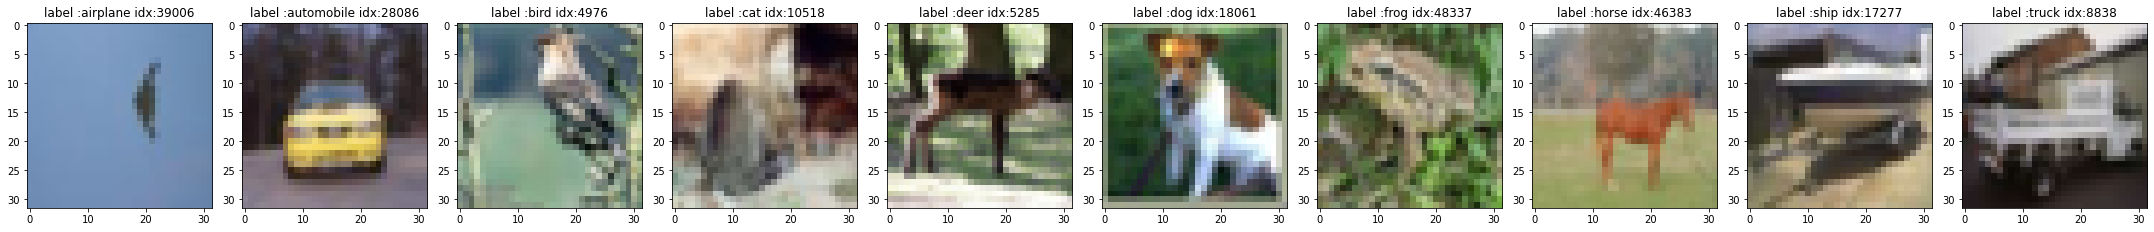

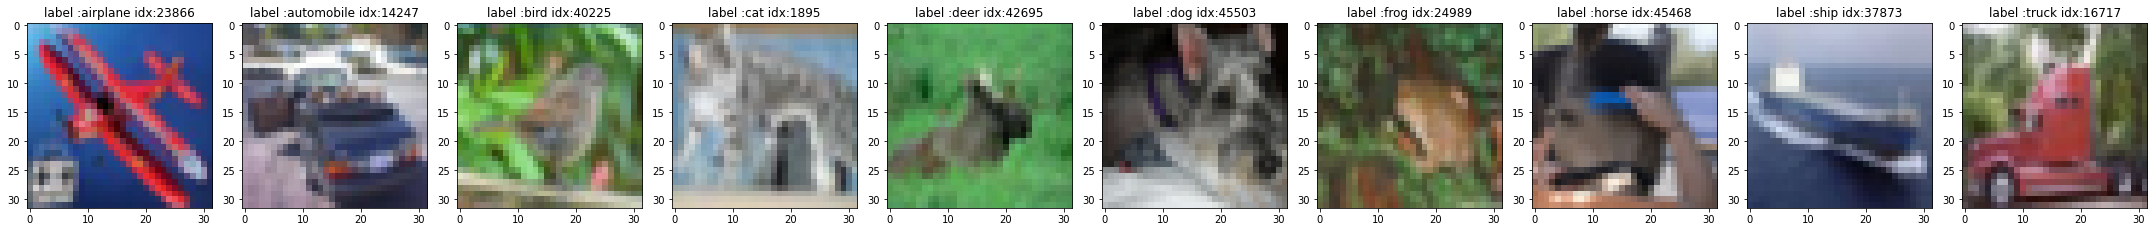

In [62]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
plot_unique_images(train,labels =labels)
plot_unique_images(train,labels =labels)

In [63]:
#Calculating mean and veriance and std

In [64]:
mean,std  = get_data_stats(train,test,img_norm_typ ='train',plot = False)

<Figure size 1080x360 with 0 Axes>

In [65]:
print(dir(A))

['Affine', 'BaseCompose', 'BasicIAATransform', 'BasicTransform', 'BboxParams', 'BboxProcessor', 'BboxType', 'Blur', 'CLAHE', 'CenterCrop', 'ChannelDropout', 'ChannelShuffle', 'CoarseDropout', 'ColorJitter', 'Compose', 'Crop', 'CropAndPad', 'CropNonEmptyMaskIfExists', 'Cutout', 'Downscale', 'DualIAATransform', 'DualTransform', 'ElasticTransform', 'Emboss', 'Equalize', 'FDA', 'FGeometric', 'FancyPCA', 'Flip', 'FromFloat', 'GaussNoise', 'GaussianBlur', 'GlassBlur', 'GridDistortion', 'GridDropout', 'HistogramMatching', 'HorizontalFlip', 'HueSaturationValue', 'IAAAdditiveGaussianNoise', 'IAAAffine', 'IAACropAndPad', 'IAAEmboss', 'IAAFliplr', 'IAAFlipud', 'IAAPerspective', 'IAAPiecewiseAffine', 'IAASharpen', 'IAASuperpixels', 'ISONoise', 'ImageCompression', 'ImageOnlyIAATransform', 'ImageOnlyTransform', 'InvertImg', 'JpegCompression', 'KeypointParams', 'KeypointType', 'KeypointsProcessor', 'Lambda', 'List', 'LongestMaxSize', 'MAX_VALUES_BY_DTYPE', 'MaskDropout', 'MedianBlur', 'MotionBlur', '

In [66]:
#Using the Albumentation module  trying to do somw augmentation

In [67]:
def augment(aug, image):
    return aug(image=image)['image']

In [68]:
#hflip

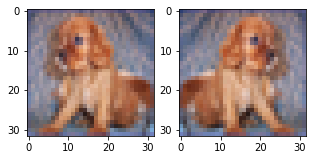

In [69]:
image = train.data[np.random.randint(0,50000)]
fig = plt.figure(figsize=(5,5))
for i in range(1,3):    
    ax = fig.add_subplot(1,2,i)
    _ = plt.imshow(image)
    image = A.hflip(image)


In [70]:
#ShiftScaleRotate

In [71]:
A.ShiftScaleRotate()

ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None)

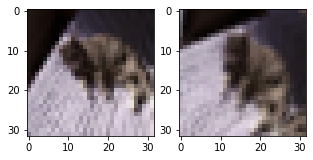

In [72]:

image = train.data[np.random.randint(0,50000)]
fig = plt.figure(figsize=(5,5))
for i in range(1,3):    
    ax = fig.add_subplot(1,2,i)
    _ = plt.imshow(image)
    aug = A.ShiftScaleRotate(always_apply=True)
    image = augment(aug,image)

In [73]:
A.CoarseDropout()

CoarseDropout(always_apply=False, p=0.5, max_holes=8, max_height=8, max_width=8, min_holes=8, min_height=8, min_width=8, fill_value=0, mask_fill_value=None)

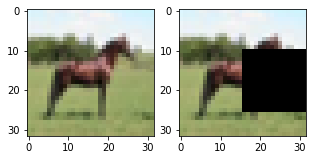

In [74]:
image = train.data[np.random.randint(0,50000)]
fig = plt.figure(figsize=(5,5))
for i in range(1,3):    
    ax = fig.add_subplot(1,2,i)
    _ = plt.imshow(image)
    aug = A.CoarseDropout(always_apply = True,max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=mean, mask_fill_value = None)
    image = augment(aug,image)

In [75]:
# dir(A.pytorch.transforms)

In [76]:
train_transform =A.Compose([A.Resize(32,32),
                            A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                            A.ShiftScaleRotate(always_apply=False),
                            A.CoarseDropout(always_apply = False,max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=mean, mask_fill_value = None),
                            ToTensorV2(transpose_mask =False),
                            ])      

In [77]:
test_transform = A.Compose([A.Resize(32,32),
                            A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                            ToTensorV2(transpose_mask =False),
                            ])

In [78]:
from torch.utils.data.dataset import Dataset

In [79]:
class AlbumDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data,transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train = train.data
        self.label = train.targets
        self.transform = transform

    def __len__(self):
        return (len(self.train))

    def __getitem__(self, idx):
        image = self.train[idx]
        image = np.array(image)
        # image = image.fromarray(image).convert('RGB')
        # image = np.asarray(image).astype(np.unit8)
        if self.transform:
            aug_image = self.transform(image= image)["image"]
            # aug_image = aug_image.T
        aug_image = torch.tensor(aug_image,dtype =torch.float)
        return aug_image,self.label[idx]

In [80]:
train_alb = AlbumDataset(train,train_transform)
test_alb = AlbumDataset(test,test_transform)

In [81]:
#create a DataHook class to get everything 

In [82]:
# t = train.data
# type(t[10])

# a = t[np.random.randint(0,50000)]
# plt.imshow(a)
# plt.show()
# plt.subplots(figsize = (10,10))
# a = train_transform(image = a)["image"]
# a.shape
# a =a.T
# # a = a[:,:,1]
# plt.imshow(a)
# plt.show()
# plt.imshow(a.T)
# a.max()
# a.max()

# for data,target in train_loader:
#     data.shape
#     target.shape
#     break

In [83]:
batch_size = 64
epochs = 25

args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
train_loader = DataLoader(train_alb,batch_size=batch_size,shuffle = True,**args)
test_loader = DataLoader(test_alb,batch_size=batch_size,**args)

In [84]:
for data, target in train_loader:
    data.shape
    break

torch.Size([64, 3, 32, 32])

In [85]:
class GhostBatchNorm(nn.BatchNorm2d):
    """
    From : https://github.com/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb

    Batch norm seems to work best with batch size of around 32. The reasons presumably have to do 
    with noise in the batch statistics and specifically a balance between a beneficial regularising effect 
    at intermediate batch sizes and an excess of noise at small batches.
    
    Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, 
    but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch 
    norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. 
    It isn't supported directly in PyTorch but we can roll our own easily enough.
    """
    def __init__(self, num_features, num_splits, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super(GhostBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias        
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super(GhostBatchNorm, self).train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)

In [86]:
def Normalize(norm_type,num_features,n_group=2):
    if norm_type == 'bn':
        return nn.BatchNorm2d(num_features = num_features)

    elif norm_type =='gn':
        return nn.GroupNorm(num_groups=n_group ,num_channels=num_features)
    
    elif norm_type =='ln':
        return nn.GroupNorm(num_groups =1, num_channels=num_features)

    elif norm_type == 'gbn':
        return  GhostBatchNorm(num_features, num_splits=4, weight=False)
        
    else:
        print ('Invalid norm Parameter, Providing Default as BN ')
        return nn.BatchNorm2d(num_features = num_features,)

In [87]:
class Depthwise_sep_conv(nn.Module):
    def __init__(self,in_channels,out_channels,dropout_val=0.1,norm_type = 'bn',stride = 1):
        super(Depthwise_sep_conv,self).__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.dropout_val = dropout_val
        self.norm_type = norm_type

        self.deptwiseseperable = nn.Conv2d(in_channels=self.in_channels, out_channels=self.in_channels,kernel_size =(3,3), stride = self.stride,padding = 1,groups = self.in_channels, bias = False)
        self.pointwise = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels,kernel_size =(1,1), stride =1, bias = False)
        self.norm = Normalize(norm_type = self.norm_type ,num_features= self.out_channels)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout2d(p = self.dropout_val)
    
    def forward(self,x):
        x = self.deptwiseseperable(x)
        x = self.pointwise(x)
        x = self.relu(x)
        x = self.drop(x)
        return x

In [88]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride,padding,kernel_size=(3,3),norm_type = 'bn' ,dropout_val = 0):
        super(ConvBlock,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride=stride
        self.padding= padding
        self.kernel_size=kernel_size
        self.norm_type = norm_type
        self.dropout_val = dropout_val

        self.conv = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels,kernel_size=self.kernel_size,stride =self.stride,padding = self.padding,bias = False)
        self.norm = Normalize(norm_type = self.norm_type ,num_features= self.out_channels)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout2d(p = self.dropout_val)

    def forward(self,x):
        x = self.relu(self.norm(self.conv(x)))
        x= self.drop(x)
        return x

In [89]:
class Cifar10Net(nn.Module):
    def __init__(self,dropout_val = 0,norm_type = 'bn'):
        super(Cifar10Net,self).__init__()
        self.norm_type = norm_type
        self.drop = dropout_val

        self.block1 = nn.Sequential(
            ConvBlock(in_channels=3,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop)
            )#Input : 32x32x3 |  Outout: 32x32x32 |  RF: 5x5
        
        self.block2 = nn.Sequential(
            ConvBlock(in_channels=32,out_channels=64,kernel_size = (3,3),stride = 2, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            Depthwise_sep_conv(in_channels=64,out_channels=64,stride = 2,norm_type = self.norm_type,dropout_val= self.drop),
            
        )#Input : 32x32x33 |  Outout: 16x16x64 |  RF: 11*11
        
        self.block3 = nn.Sequential(
            ConvBlock(in_channels=64,out_channels=64,kernel_size = (3,3),stride = 1, padding = 0,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=64,out_channels=32,kernel_size = (1,1),stride = 1, padding = 0,norm_type = self.norm_type,dropout_val= self.drop)
            
            
        )#Input : 16x16x64 |  Outout: 16x16x64 |  RF: 15x15
        
        self.block4 = nn.Sequential(
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 0,norm_type = self.norm_type,dropout_val= self.drop)
            
        )#Input : 32x32x3 |  Outout: 32x32x32 |  RF: 5x5

        self.block5 = nn.Sequential(
            Depthwise_sep_conv(in_channels=32,out_channels=64,stride = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=64,out_channels=128,kernel_size = (1,1),stride = 1, padding = 0,norm_type = self.norm_type,dropout_val= self.drop)
            
        )#Input : 32x32x3 |  Outout: 32x32x32 |  RF: 5x5

        self.gap = nn.AvgPool2d(kernel_size = (4,4),stride = 1)

        self.fc1 = nn.Linear(in_features =128,out_features = 10 )
        # # arch

    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.gap(x)
        x = x.view(-1,128)
        x = self.fc1(x)
        return F.log_softmax(x,dim = -1)
        # return F.nll_loss(x)


In [90]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
model = Cifar10Net(norm_type='bn',dropout_val=0.01).to(device)
rf_df = receptive_field(model,32)
summary(model,input_size=(3,32,32))

=======================================Reciptive Field Calculator========================================
|    | Kernel_size   | Padding   |   Stride | Input_Img_size   | Output_Img_size   | Receptive_field   |
|---:|:--------------|:----------|---------:|:-----------------|:------------------|:------------------|
|  0 | 3*3           | 1         |        1 | 32*32            | 32*32             | 3*3               |
|  1 | 3*3           | 1         |        1 | 32*32            | 32*32             | 5*5               |
|  2 | 3*3           | 1         |        2 | 32*32            | 16*16             | 7*7               |
|  3 | 3*3           | 1         |        2 | 16*16            | 8*8               | 11*11             |
|  4 | 1*1           | NO        |        1 | 8*8              | 8*8               | 11*11             |
|  5 | 3*3           | NO        |        1 | 8*8              | 6*6               | 19*19             |
|  6 | 1*1           | NO        |        1 | 6*6     

In [91]:
#Trying to explore
# for data,target in train_loader:
#     data = data.to(device)
#     target = target.to(device)
#     break
# model.train()
# op = model(data)
# op1 = F.log_softmax(op,dim = -1)
# op1.argmax(keepdim= True).eq(target).sum().item()

In [93]:
def clean_gpu():
    """Considering we have GPUs"""

    gc.collect()
    torch.cuda.empty_cache()
    return None

#L1 Loss
def get_optimizer(model_obj,loss_type=None,scheduler = False):
    loss_type= str(loss_type).upper()
    parameters = model_obj.parameters()
    if loss_type  == 'L2' :
        optimizer = SGD( params = parameters,lr = 0.01,momentum = 0.9,weight_decay= 0.001)
    else:
        optimizer = SGD( params = parameters,lr = 0.01,momentum = 0.9)
    if scheduler == True:
        scheduler = StepLR(optimizer,step_size = 6,gamma = 0.1)
        return optimizer,scheduler
    else:
        return optimizer,_

def L1_loss(model_obj,loss):
        
    l1 = 0
    lambda_l1 = 0.0001
    for p in model_obj.parameters():
        l1 = l1+p.abs().sum()
        loss = loss+ lambda_l1* l1
    return loss

def plot_acc_loss(typ ,train_acc,train_losses,test_acc,test_losses):
    fig, axs = plt.subplots(1,2,figsize = (20,5))
    # print ('Accuracy model on  ', typ)
    plt.autoscale()
    axs[0].plot(train_acc,color = 'red')
    axs[0].plot(test_acc,color = 'green')
    title = 'Training/testing accuracy'
    axs[0].set_title(title)
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train acc','test acc'], loc='best')
       
    axs[1].plot(train_losses,color = 'red')
    axs[1].plot(test_losses,color = 'green')
    title = 'Training/Testing Loss'
    axs[1].set_title(title)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train loss','test loss'], loc='best')
    plt.title(typ + ' model Accuracy Vs Loss')

    plt.show()
    fig.tight_layout(pad = 1.0)

In [94]:
train_losses = []
train_accuracy = []
test_losses =[]
test_accuracy = []

def trainning(model,device,train_data,optimizer,epochs,L1 = False,L2= False):
    total_loss = 0
    correct = 0
    processed = 0

    model.train()
    pbar = tqdm(train_loader,colour = '\x1b[34m')
    
    for index_id,(data,target) in enumerate(pbar):
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        if L1 == True:
            loss = L1_loss(model,loss)

        total_loss += loss
        loss.backward()
        optimizer.step()
        correct += output.argmax(dim = 1).eq(target).sum().item()
        processed += len(data)
        pbar.set_description(f"Train ==> Epochs: {epochs} Batch:  {index_id} loss: {loss} Accuracy: { correct/processed *100 :.2f}% ")

    acc = correct /processed
    total_loss = total_loss.item()/processed
    train_losses.append(total_loss)
    train_accuracy.append(acc)

    return train_losses, train_accuracy


def testing(model,device,test_data,optimizer,epochs):
    model.eval()
    
    test_loss = 0
    correct = 0
    processed = 0
    pbar= tqdm(test_loader)
    with torch.no_grad():
        for id_x,(data,target) in enumerate(pbar):
            data,target = data.to(device),target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output,target,reduce='sum').item()
            pred  = output.argmax(dim =1,keepdim = True)

            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            
            pbar.set_description(f"Test ==> Epochs: {epochs} Batch:  {id_x} loss: {test_loss/processed} Accuracy: { correct / processed *100 :.2f}% ")
        
    acc = correct / processed
    test_loss /= processed
    test_accuracy.append(acc)
    test_losses.append(test_loss)
   
    
    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
    #     test_loss, correct, processed, 100. * correct / processed))
    
    return test_losses,test_accuracy


def print_wrong_image(model,device,data,label,n_images):
    if n_images >= 10:
        n_images = 10
    for data,target in data:
        data.to(device),target.to(device)
    with torch.no_grad():

        out = model((data/255).to(torch.float32).reshape(-1,1,28,28).to(device))
    
    wrong_idx = (out.to(device).argmax(dim = 1).eq(label.to(device)) ==False).nonzero()
    label = label.to('cpu')
    img_data = (data/255).to(torch.float32).to('cpu')
    wrong_idx = wrong_idx.to('cpu').squeeze()
    # print (wrong_idx.shape)
    # wrong_idx
    np.random.shuffle(wrong_idx.numpy())
    fig = plt.figure(figsize=(20,30))
    count = 1
    for image_index in wrong_idx:
        n= image_index
        ax = fig.add_subplot(1,10,count)
        _=plt.imshow((img_data[n].reshape(28,28).to('cpu')))
        _=plt.title(f"idx:{n }")
        _=plt.xlabel(f"Act:{label[n].item()} ")
        _=plt.ylabel(f"Pred: {out.argmax(dim = 1)[n].item()} ")
        _ = plt.autoscale()
        fig.tight_layout(pad = 1.0)
        count+= 1
        if count==11:
            break
    plt.show()

In [95]:
def Run_Model(model_class,train_loader,test_loader,epochs , L1 = False):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print (f'running on {device} \n')
    #take input as normal_type ['gbn','bn','gn','ln']
    model = model_class.to(device)
    try:
        summary(model,input_size = (3,32,32))
    except:
        pass

    optimizer,scheduler = get_optimizer(model,scheduler = True )
    # optimizer = SGD( params = model.parameters(),lr = 0.01,momentum = 0.9)
    for EPOCHS in range(0,epochs):
        if L1 == True:
            train_losses, train_accuracy = trainning(model,device,train_loader,optimizer,EPOCHS,L1 = L1)
        else:
            train_losses, train_accuracy = trainning(model,device,train_loader,optimizer,EPOCHS)
        test_losses,test_accuracy = testing(model,device,test_loader,optimizer,EPOCHS)
        scheduler.step()
    return model,train_losses, train_accuracy,test_losses,test_accuracy

Files already downloaded and verified
Files already downloaded and verified
running on cuda 



Train ==> Epochs: 0 Batch:  781 loss: 1.9523917436599731 Accuracy: 34.31% : 100%|██████████| 782/782 [00:18<00:00, 42.19it/s]
Test ==> Epochs: 0 Batch:  781 loss: 0.020965701336860657 Accuracy: 50.96% : 100%|██████████| 782/782 [00:10<00:00, 71.46it/s]
Train ==> Epochs: 1 Batch:  781 loss: 2.045097589492798 Accuracy: 44.09% : 100%|██████████| 782/782 [00:18<00:00, 42.18it/s]
Test ==> Epochs: 1 Batch:  781 loss: 0.020076025984287264 Accuracy: 54.37% : 100%|██████████| 782/782 [00:11<00:00, 69.37it/s]
Train ==> Epochs: 2 Batch:  781 loss: 1.2652008533477783 Accuracy: 49.17% : 100%|██████████| 782/782 [00:18<00:00, 42.10it/s]
Test ==> Epochs: 2 Batch:  781 loss: 0.01627069251656532 Accuracy: 63.30% : 100%|██████████| 782/782 [00:11<00:00, 68.44it/s]
Train ==> Epochs: 3 Batch:  781 loss: 1.4503928422927856 Accuracy: 52.75% : 100%|██████████| 782/782 [00:18<00:00, 42.55it/s]
Test ==> Epochs: 3 Batch:  781 loss: 0.014759670748710632 Accuracy: 66.29% : 100%|██████████| 782/782 [00:11<00:00, 6

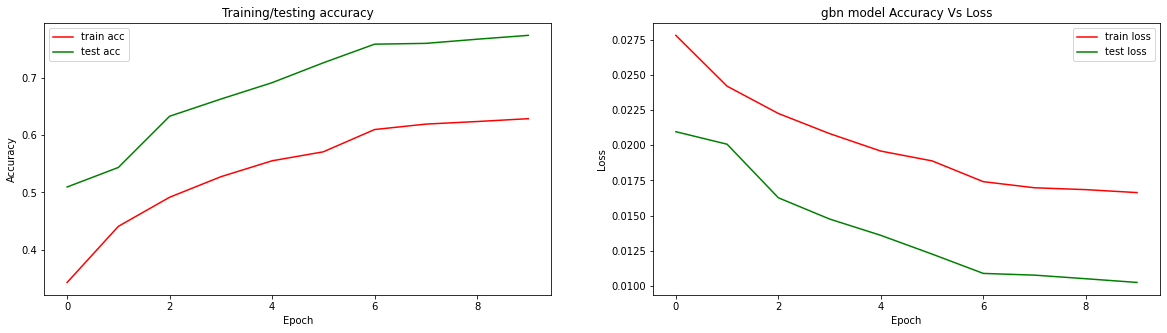

In [96]:
if __name__ == "__main__":
    batch_size = 64
    epochs = 10

    _=torch.manual_seed(1)
    if torch.cuda.is_available():
        _=torch.cuda.manual_seed(1)

    train,test = get_data()
    #take input as normal_type ['gbn','bn','gn','ln']

    args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
    train_loader = DataLoader(train_alb,batch_size=batch_size,shuffle = True,**args)
    test_loader = DataLoader(test_alb,batch_size=batch_size,**args)
    # ['gbn','bn','gn','ln']
    try_type = ['gbn']
    for norm_type in try_type:

        model_class = Cifar10Net(dropout_val=0.01,norm_type=norm_type)
        model,train_losses, train_accuracy,test_losses,test_accuracy = Run_Model(model_class,train_alb,test_alb,epochs =epochs)
        plot_acc_loss(norm_type ,train_accuracy,train_losses,test_accuracy,test_losses)
        clean_gpu()
    
        # test_data = test.test_data
        # test_labels = test.test_labels
        # print_wrong_image(model ,device,test_data,test_labels,n_images = 10)
        clean_gpu()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # functions to show an image


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))


# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

NameError: ignored

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))